# Realtime Facial Expression Recogniton 😎

Dieses Jupyter Notebook interpretiert mithilfe der Webcam die Mimik des Anwenders.
Für die Gesichtserkennung wird OpenCV eingesetzt.

Das Neuronale Netz wurde mithilfe von Keras und Tensorflow entwickelt.

### Setup

Um dieses neuronale Netz nutzen zu können, müssen Sie folgendes Durchführen:
1. Download des Datensatzes FER2013 bei Kaggle https://www.kaggle.com/datasets/msambare/fer2013
2. Legen Sie die 'test' und 'train' Ordner in einen 'data' Ordner
3. Legen Sie einen predict Ordner im 'data' Ordner an mit einer Testdatei
4. Viel Spaß beim ausprobieren 🤟

**Achtung**

Bitte beachte, für die Realtime Erkennung darf nur eine Kamera angeschlossen sein

## Importieren der notwendigen Bibliotheken

### Importieren von Python Bibliotheken, um die Datensätze für das Lernen vorzubereiten

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
import os
import cv2

### Importieren von keras und tensorflow für das machine learnings 

In [10]:
from keras import models 
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
from tensorflow.keras.utils import plot_model
from keras.models import Sequential

### Laden der Statischen Datensätze

Die Nachfolgende Methode zählt, wieviele Bilder in den Untergeordneten Ordnern existieren und stellt diese in einem Diagramm dar.

In [11]:
def getData(name):  
    main=os.listdir(f'./data/{name}')
    dic={}
    dir=f'./data/{name}'
    print(main)
    for i in main:
        initial_count = 0
        dirr=os.path.join(dir, i)
        for path in os.listdir(dirr):
            if os.path.isfile(os.path.join(dirr, path)):
                initial_count += 1
        dic[i]=initial_count
    courses = list(dic.keys())
    values = list(dic.values())

    fig = plt.figure(figsize = (10, 5))
    plt.bar(courses, values, color ='blue',
            width = 0.5)
    plt.savefig(f'{name}_data_info_face_dataset')

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']


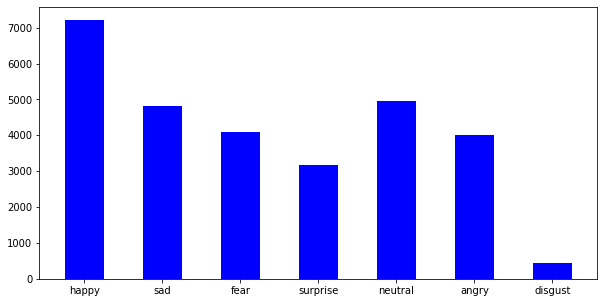

In [12]:
getData('train')

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']


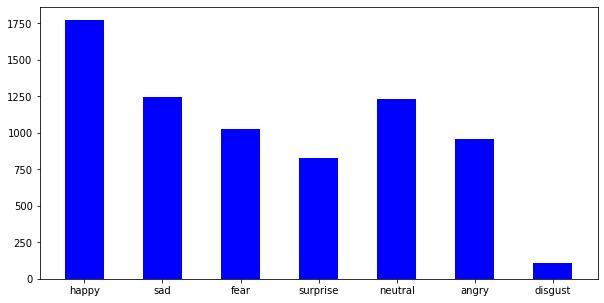

In [13]:
getData('test')

## Vorbereiten der Test-und Validierungsdatensätze

Nachfolgend werden die entsprechenden Bilder für die Test- und Validierungsdatensätze vorbereitet und anschließend geladen.

Mithilfe des ImageDataGenerator bringen wir die Bilder in die optimale Form für unser neuronales Netz. In diesem Schritt werden beispielsweise alle Werte durch 255 geteilt, um Werte zwischen 0 und 1 zu erhalten. Dadurch können wir die Performance des Netzes steigern. 

Tensorflow stellt außerdem die flow_from_directory() Methode bereit, welche die Dateien im Anschluss aus den Unterverzeichnissen lädt und gleichzeitig den Bildern die Labels gibt. Als Wert für die Labels wird hier immer der Name des Ordners verwendet. Des Weiteren verändern wir die Maße der Bilder auf 100*100 Pixel. Als Farbmodus wird Schwarz/Weiß verwendet, da wir das Echtzeit Bild später auch in Schwarz Weiß auslesen.


In [14]:
train_dir = r'./data/train'
test_dir = r'./data/test'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(100,100),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(100,100),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Das Neuronale Netz

In der Folgenden Methode wird die Struktur unseres Modells definiert. Nach ausführlichen Recherchen konnnten wir folgenden Aufbau entwickeln, der die beste Treffergenauigkeit im Vergleich erzielen konnte. Was auffällt ist, dass wir zwei mal einen ähnlichen Block aus 5 Schichten einsetzen, was die Grundstruktur unseres Netzes darstellt. Darauf Folgen weitere Schichten, die die Messergebnisse noch etwas verfeinern. Als Optimizer setzen wir Adam ein, da sich dieser als sehr effizienter Optimizer für Bildklassifikationen eignet.

In [15]:
#Definieren des Neuronalen Netzes

def get_model(input_size, classes=7):
    model = Sequential()   
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [16]:
classes=7
my_model = get_model((100,100,1), classes)
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 50, 50, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                      

## Starten des Modells

Nachfolgend wir das Modell mithilfe der Fit Methode trainiert. Durch mehrere Versuche konnten wir die Anzahl der Epochen von 65 als optimale Menge ermitteln. Des Weiteren wird empfohlen die Schritte pro Epoche und die Schritte pro Validierung dynamisch anhand vorhandener Datensätze festzulegen.

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = my_model.fit(x=training_set,
                 validation_data=test_set,
                 epochs=231,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

my_model.save('./saved_model/')




## Auswerten der Modell Performance
Im Folgenden wird die Modell nochmal anhand der Trainingsdatensätze evaluiert und in einem Diagramm dargestellt.

In [17]:
train_loss, train_accu = my_model.evaluate(training_set)
test_loss, test_accu = my_model.evaluate(test_set)

print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 45s 397ms/step - loss: 1.2687 - accuracy: 0.6743
final train accuracy = 96.42 , validation accuracy = 67.43


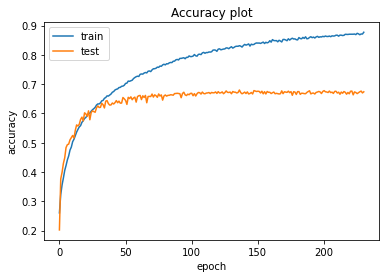

In [80]:
hist = hist.history
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("emotion_model_accuracy.png")

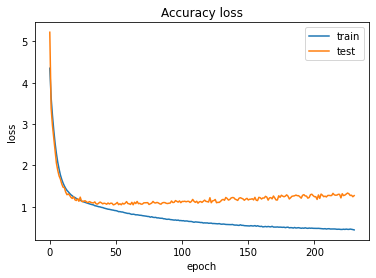

In [81]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("emotion_model_loss.png")

## Laden des Modells
Um das Modell direkt verwenden zu können, verwenden wir die load_model Methode, die direkt auf das zuvor gespeicherte Modell zurückgreift

In [17]:
my_model = tf.keras.models.load_model('./saved_model/')

## Confusion Matrix für die tatsächliche Treffergenauigkeit
Im Folgenden wird eine Confusion Matrix dargestellt, die uns mehr Informationen über die Aussagekraft des Modells bereitstellt.

In [18]:
from sklearn.metrics import confusion_matrix

In [ ]:
predictions = my_model.predict(test_set)

In [ ]:
rounded_predictions = np.argmax(predictions, axis=-1)

In [ ]:
test_labels = test_set.labels
cm = confusion_matrix(y_true=test_labels, y_pred=rounded_predictions)

In [14]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']

Confusion matrix, without normalization
[[131  11  99 228 188 196 105]
 [ 17   2  11  27  17  21  16]
 [147   9 114 244 177 215 118]
 [242  19 222 440 342 325 184]
 [178  15 154 298 240 221 127]
 [174  11 141 331 226 229 135]
 [104   5  99 232 154 140  97]]


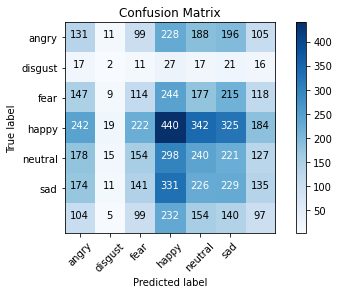

In [16]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


Betrachtet man die Confusion Matrix, fällt auf, dass die Treffergenauigkeit stark von der Anzahl der vorhandenen Test- und Validierungsdatensätze abhängt. Während Happy häufig richtig erkannt wurde, konnte das Netz  Disgusting deutlich schlechter klassifizieren.

## Gesichtserkennung durch OpenCV

Bevor wir die Mimik des Nutzers interpretieren können, müssen wir das Gesicht des Nutzers erkennen. Hierfür eignet sich die Bildanalyse Bibliothek OpenCV. OpenCV nutzt zur Gesichtserkennung die Markanten Merkmale eines Gesichts (Augen, Nase, Mund, Ohren).

Folgende Grafik veranschaulicht den Prozess, wie OpenCV die Gesichtserkennung vornimmt:



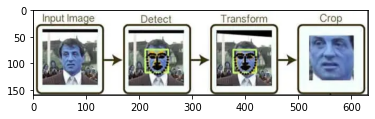

In [20]:
frame = cv2.imread('./opencv.png')
plt.imshow(frame)

Angelehnt an: https://pyimagesearch.com/2018/09/24/opencv-face-recognition/

### Implementierung der Gesichtserkennung

Nachfolgend wird die Gesichtserkennung an einem statischen Bild implementiert: 

In [37]:

frame = cv2.imread('./test_face.jpeg')

In [38]:
frame.shape

(360, 600, 3)

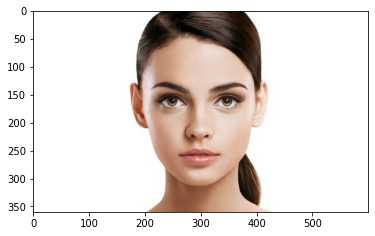

In [39]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

OpenCV verfügt über eine Vielzahl an unterschiedlichen Gesichtserkennungen. Nachfolgend wird die Konfiguration für das Erkennen von frontal ausgerichteten Gesichtern referenziert:

In [40]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_frontalface_default.xml")

In [41]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


In [42]:
gray.shape

(360, 600)

In [43]:
faces = faceCascade.detectMultiScale(gray, 1.1, 4)

for x,y,w,h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0),2)
    face_roi = roi_color[ey: ey+eh, ex:ex+ew]

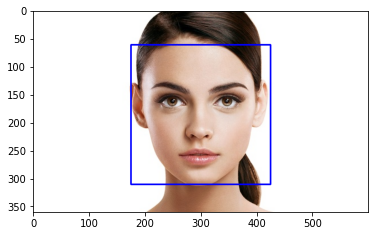

In [44]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB ))

Nun können wir sehen, dass OpenCV einen blauen Rahmen um das Gesicht gelegt hat.

## Testen des Neuronalen Netzes

Bevor wir die Bereiche kombinieren, um die echtzeit Gesichtserkennung durchführen zu können, testen wir noch einmal die Performance unseres Netzes an einem statischen Bild. Im Idealfall sollte das Netz erkennen, dass Kevin Angst hat.

Kevin hat Angst 🎉


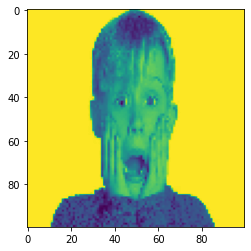

In [29]:
from tensorflow.keras.preprocessing import image

dir_path = './data/predict'

for i in os.listdir(dir_path):
    img = image.load_img(dir_path+'//'+i, target_size=(100,100), color_mode="grayscale")
    plt.imshow(img);
    
    X = image.img_to_array(img)
    
    X = np.expand_dims(X, axis = 0)
    X = X/255
    images = np.vstack([X])
    val=my_model.predict(images)
    if (np.argmax(val[0]) == 2):
        print("Kevin hat Angst 🎉")
    else:
        print("Unser Netz konnte die Angst von Kevin nicht erkennen")



# Realtime Video prediction


Nachdem wir alle Komponenten erfolgreich entwickelt, implementiert und getestet haben, können wir im nächsten Schritt alle Komponenten mit der Echtzeiterkennung verknüpfen. Im ersten Schritt definieren wir hierfür notwendige Variablen:


In [30]:
path = 'haarcascade_frontalface_default.xml'
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN
rectangle_bgr = (255,255,255)

img = np.zeros((500,500))

text = ""

(text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]

text_offset_x = 10
text_offset_y = img.shape[0] -25

box_coords = ((text_offset_x, text_offset_y), (text_offset_x+text_width+2, text_offset_y-text_height-2))

cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
font = cv2.FONT_HERSHEY_SIMPLEX
  
org = (50, 50)
  
fontScale = 1
   
color = (255, 0, 0)
thickness = 2
cv2.putText(img, 'OpenCV', org, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
face_roi = None


Zu guter letzt starten wir die Webcam:

In [33]:
vid = cv2.VideoCapture(0)

Und lesen dauerhaft das Bild ein und übergeben dieses an unser Modell. Bevor wir dieses übergeben können, müssen wir es in die gewünschte Form bringen:

In [34]:


while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Ermittlung aller im Bild enthaltenen Gesichter
    faces = faceCascade.detectMultiScale(gray, 1.1,4)
    
    #Iteration über jedes Bild und entsprechende Anpassung der Bildmaße und Bildwerte
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = gray[y:y+h, x:x+w]
        cv2.rectangle(gray, (x,y), (x+w, y+h), (255,0,0),2)
        face_roi = roi_color
    if(face_roi is not None):
        image = cv2.resize(face_roi, (100,100))
        X = np.expand_dims(image, axis = 0)
        X = X/255
        images = np.vstack([X])

        #Jetzt können wir mit unserem Modell eine Vorhersage treffen:
        val=my_model.predict(images)

        prediction_value = np.argmax(val[0])

        #Interpretation der Prediction:
        if(prediction_value == 0):
            status = "Angry"
            x1,y1,w1,h1 = 0,0,175,75
            cv2.rectangle(gray, (x1,x1), (x1+w1,y1+h1), (0,0,0), -1)
            cv2.putText(gray, status, (x1+int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

            cv2.putText(gray, status,(100,150), font, 3,(0,0,255), 2, cv2.LINE_4)
            cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255))
        elif (prediction_value == 1):
            status = "Disgust"
            x1,y1,w1,h1 = 0,0,175,75
            cv2.rectangle(gray, (x1,x1), (x1+w1,y1+h1), (0,0,0), -1)
            cv2.putText(gray, status, (x1+int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

            cv2.putText(gray, status,(100,150), font, 3,(0,0,255), 2, cv2.LINE_4)
            cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255))
        elif (prediction_value == 2):
            status = "Fear"
            x1,y1,w1,h1 = 0,0,175,75
            cv2.rectangle(gray, (x1,x1), (x1+w1,y1+h1), (0,0,0), -1)
            cv2.putText(gray, status, (x1+int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

            cv2.putText(gray, status,(100,150), font, 3,(0,0,255), 2, cv2.LINE_4)
            cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255))
        elif (prediction_value == 3):
            status = "Happy"
            x1,y1,w1,h1 = 0,0,175,75
            cv2.rectangle(gray, (x1,x1), (x1+w1,y1+h1), (0,0,0), -1)
            cv2.putText(gray, status, (x1+int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

            cv2.putText(gray, status,(100,150), font, 3,(0,0,255), 2, cv2.LINE_4)
            cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255))
        elif (prediction_value == 4):
            status = "Neutral"
            x1,y1,w1,h1 = 0,0,175,75
            cv2.rectangle(gray, (x1,x1), (x1+w1,y1+h1), (0,0,0), -1)
            cv2.putText(gray, status, (x1+int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

            cv2.putText(gray, status,(100,150), font, 3,(0,0,255), 2, cv2.LINE_4)
            cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255))
        elif (prediction_value == 5):
            status = "Sad"
            x1,y1,w1,h1 = 0,0,175,75
            cv2.rectangle(gray, (x1,x1), (x1+w1,y1+h1), (0,0,0), -1)
            cv2.putText(gray, status, (x1+int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

            cv2.putText(gray, status,(100,150), font, 3,(0,0,255), 2, cv2.LINE_4)
            cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255))
        elif (prediction_value == 6):
            status = "Suprised"
            x1,y1,w1,h1 = 0,0,175,75
            cv2.rectangle(gray, (x1,x1), (x1+w1,y1+h1), (0,0,0), -1)
            cv2.putText(gray, status, (x1+int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

            cv2.putText(gray, status,(100,150), font, 3,(0,0,255), 2, cv2.LINE_4)
            cv2.rectangle(gray, (x,y), (x+w, y+h), (0,0,255))


    cv2.imshow('Face Emotion Recognition', gray)
    if(cv2.waitKey(2) & 0xFF == ord('q')):
        break



    
    #Durch die eingabe von 'q' kann die Webcamaufnahme beendet werden
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

vid.release()
cv2.destroyAllWindows()


    